In [1]:
import os
import base64
from fuzzywuzzy import fuzz
from itertools import combinations
import xml.etree.ElementTree as ET
import random

In [2]:
# функция для чтения файлов из директории
def export_files(directory):
    files = []
    for filename in os.listdir(directory):
        if filename.endswith(".xml"):
            tree = ET.parse(os.path.join(directory, filename))
            root = tree.getroot()
            name = filename
            for elem in root.iter():
                if elem.text:
                    text = (elem.text.strip() if elem.attrib.get('encoding') != 'base64' else base64.b64decode(elem.text).decode('cp1251'))
                    if len(text) and elem.tag == '{http://www.romip.ru/data/common}subject':
                        name = text
                    if len(text) and elem.tag == '{http://www.romip.ru/data/common}content':
                        files.append((name, text))
    return files

In [3]:
# создание шинглов 
def create_shingles(text, shingle_len):
    return {text[i:i+shingle_len] for i in range(len(text) - shingle_len + 1)}

In [4]:
# функция для поиска нечетких дубликатов в коллекции текстов
def find_fuzzy_duplicates(text, threshold, shingle_len):
    duplicates = []
    for pair in combinations(text, 2):
        text1 = pair[0][1]
        text2 = pair[1][1]
        # берем 2 набора шинглов
        shingles1 = create_shingles(text1, shingle_len)
        shingles2 = create_shingles(text2, shingle_len)
        #вычисляем коэф схожести двух шинглов
        intersection = len(shingles1.intersection(shingles2))
        union = len(shingles1.union(shingles2))
        sim = intersection / union
        #Если отношение схожести токенов также превышает пороговое значение, 
        #то пара документов считается нечетким дубликатом и добавляется 
        #в список duplicates
        if sim >= threshold:
            ratio = fuzz.token_sort_ratio(text1, text2)
            duplicates.append((pair[0][0], pair[1][0], sim, ratio))
    return duplicates

In [5]:
directory = "/eos/user/a/aegorych/labs"
files = export_files(directory)
shingle_len = 4
threshold = 0.3
text = files[0:500]
duplicates = find_fuzzy_duplicates(text, threshold, shingle_len)

In [6]:
print("Длина шингла:", shingle_len)
print(f"Процент дубликатов: {len(duplicates)/len(files)*100:.2f} %")
print("Кластеры нечетких дубликатов:")
for i, dup in enumerate(duplicates):
    print(f"Кластер {i+1}: {dup[0]} - {dup[1]}")
    print(f"сходство двух дубликатов: {dup[2]:.2f}")
    print(f"сравнение с fuzzywuzzy: {dup[3]}%")

Длина шингла: 4
Процент дубликатов: 0.04 %
Кластеры нечетких дубликатов:
Кластер 1: В Грозном задержаны два участника незаконных вооруженных формирований - В Грозном задержаны двое участников бандформирований
сходство двух дубликатов: 0.37
сравнение с fuzzywuzzy: 67%
Кластер 2: В Москве прогремел взрыв - В результате взрыва в Москве погибли 5 человек
сходство двух дубликатов: 0.37
сравнение с fuzzywuzzy: 69%
Кластер 3: Нижегородцы на выборах в Госдуму предпочли правых либеральным демократам - Нижегородский губернатор не уйдет в Госдуму
сходство двух дубликатов: 0.31
сравнение с fuzzywuzzy: 64%
Кластер 4: Из горящего здания в Апраксином дворе эвакуируют людей - Пожар в Апраксином дворе в Петербурге локализован
сходство двух дубликатов: 0.31
сравнение с fuzzywuzzy: 60%
Кластер 5: В новогодние праздники могут быть вдвое снижены тарифы на услуги связи - Междугородные телефонные переговоры и телеграфные услуги на время праздников подешевеют
сходство двух дубликатов: 0.34
сравнение с fuzzywu

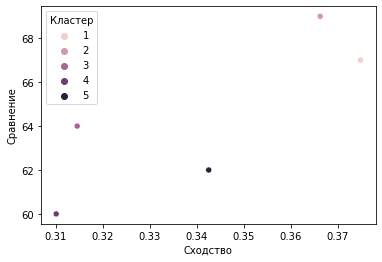

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
cluster_data = []
for i, dup in enumerate(duplicates):
    cluster_data.append((i+1, dup[2], dup[3]))

df = pd.DataFrame(cluster_data, columns=['Кластер', 'Сходство', 'Сравнение'])
sns.scatterplot(data=df, x='Сходство', y='Сравнение', hue='Кластер')
plt.show()